In [2]:
import coinmetrics
import numpy as np
import datetime as dt
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pca import pca
from sklearn import preprocessing
from scipy import stats
from scipy.cluster import hierarchy

plt.rcParams["figure.figsize"] = (20,10)

In [17]:
cm = coinmetrics.Community()
moneda = 'eth'
available_data_types = cm.get_available_data_types_for_asset(moneda)

metrica = "AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMrktCurUSD,DiffMean,FeeMeanNtv,\
FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,HashRate,IssContNtv,IssContPctAnn,IssContUSD,IssTotNtv,IssTotUSD,\
NVTAdj,NVTAdj90,PriceBTC,PriceUSD,ROI1yr,ROI30d,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,\
TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,\
VtyDayRet30d,VtyDayRet60d"

begin_timestamp = "2000-01-01"
end_timestamp = '2020-11-28'
asset_data = cm.get_asset_data_for_time_range(moneda, metrica ,begin_timestamp, end_timestamp)

In [18]:
start_time = time.time()
db = coinmetrics.cm_to_pandas(asset_data)
db.index = np.arange(len(db))
db = db.interpolate(method='polynomial', order=2)
end_time = time.time()
print("Segundos", end_time - start_time)

Segundos 0.2268357276916504


In [19]:
for name in db.columns:
    db[name] = db[name].fillna(0)    

In [20]:
Q1 = db.quantile(0.25)
Q3 = db.quantile(0.75)
IQR = Q3 - Q1

db = db[~((db < (Q1 - 1.5 * IQR)) |(db > (Q3 + 1.5 * IQR))).any(axis=1)]

In [21]:
df = pd.DataFrame(db.values)
df.columns = db.columns

In [22]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

def m_detectOutliers(data, extreme=False):
    robust_cov = MinCovDet().fit(data)
    m = robust_cov.mahalanobis(data)
    # one popular way to specify the threshold
    me = np.mean(m)
    t = 3. * me if extreme else 2. * me
    outliers = []
    for i in range(len(m)):
        if m[i] > t:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

df_wo = df.drop(m_detectOutliers(df, extreme = False))

/home/sacbe/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (386.989018536561332 > 375.159843158665751). You may want to try with a higher value of support_fraction (current value: 0.524).
  warnings.warn("Determinant has increased; this should not happen: "
/home/sacbe/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (376.642753204831820 > 357.905918780131685). You may want to try with a higher value of support_fraction (current value: 0.524).
  warnings.warn("Determinant has increased; this should not happen: "
/home/sacbe/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (383.064881436810481 > 374

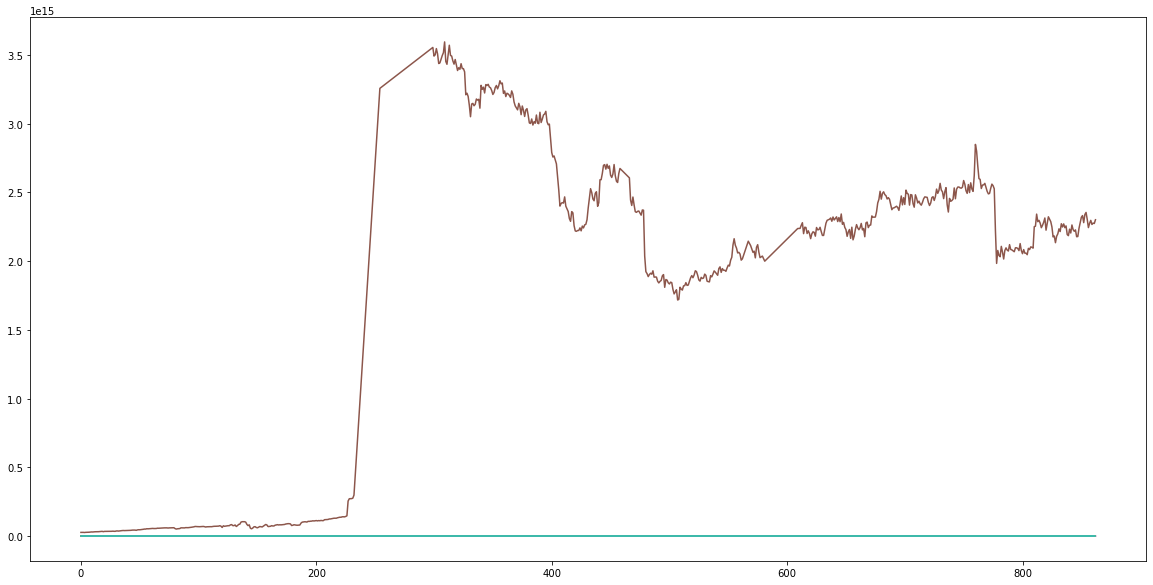

In [23]:
plt.plot(df_wo)
plt.show()

In [24]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [26]:
X = df_wo[['AdrActCnt','BlkCnt','BlkSizeByte','BlkSizeMeanByte','CapMrktCurUSD','DiffMean','FeeMeanNtv','FeeMeanUSD','FeeMedNtv','FeeMedUSD','FeeTotNtv','FeeTotUSD','HashRate','IssContNtv','IssContPctAnn','IssContUSD','IssTotNtv','IssTotUSD','NVTAdj','NVTAdj90','PriceBTC','ROI1yr','ROI30d','SplyCur','SplyExpFut10yrCMBI','SplyFF','TxCnt','TxTfrCnt','TxTfrValAdjNtv','TxTfrValAdjUSD','TxTfrValMeanNtv','TxTfrValMeanUSD','TxTfrValMedNtv','TxTfrValMedUSD','TxTfrValNtv','TxTfrValUSD','VtyDayRet180d','VtyDayRet30d','VtyDayRet60d']]
y = df_wo['PriceUSD']

X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), train_size   = 0.8, random_state = 1234, shuffle = True)

In [27]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.862e+05
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        23:13:20   Log-Likelihood:                -755.80
No. Observations:                 601   AIC:                             1556.
Df Residuals:                     579   BIC:                             1652.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0002   1.02

## Eliminamos las variables con p-value < 0.05 ya que no aportan de forma significativa al modelo

## De 40 variables a 31

In [28]:
df_regresion_wo = df_wo.drop(['BlkCnt','FeeTotNtv','FeeTotUSD','NVTAdj','ROI1yr','ROI30d','SplyExpFut10yrCMBI','TxTfrValMeanNtv','VtyDayRet180d'], axis=1)

In [29]:
#x = df_wo.values
x = df_regresion_wo.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
#df.columns = df_wo.columns
df.columns = df_regresion_wo.columns

In [30]:
model = pca()
# Fit transform
out = model.fit_transform(df)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [31] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [31]:
print(out['topfeat'])

      PC          feature   loading  type
0    PC1   TxTfrValMedNtv  0.322731  best
1    PC2     VtyDayRet60d  0.348895  best
2    PC3   TxTfrValAdjNtv -0.492738  best
3    PC4     VtyDayRet60d  0.643820  best
4    PC5        FeeMedNtv  0.512452  best
5    PC6         NVTAdj90  0.840151  best
6    PC7         NVTAdj90 -0.462635  best
7    PC8     VtyDayRet30d  0.615584  best
8    PC9         PriceBTC  0.686547  best
9   PC10     VtyDayRet60d  0.378309  best
10  PC11  BlkSizeMeanByte -0.438204  best
11  PC12  BlkSizeMeanByte  0.412256  best
12  PC13       FeeMeanUSD  0.334739  best
13  PC14   TxTfrValMedUSD -0.366209  best
14  PC15   TxTfrValMedUSD -0.518076  best
15  PC16        AdrActCnt  0.473570  best
16  PC17   TxTfrValMedNtv -0.425348  best
17  PC18   TxTfrValMedNtv -0.635646  best
18  PC19         TxTfrCnt  0.525211  best
19  PC20            TxCnt -0.697506  best
20  PC21         HashRate -0.547453  best
21  PC22        FeeMedUSD  0.491934  best
22  PC23      TxTfrValNtv -0.56337

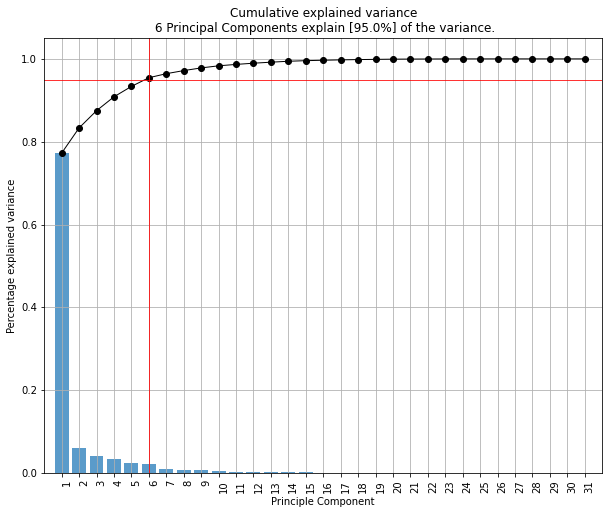

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0823f0b970>)

<Figure size 1440x720 with 0 Axes>

In [32]:
model.plot()

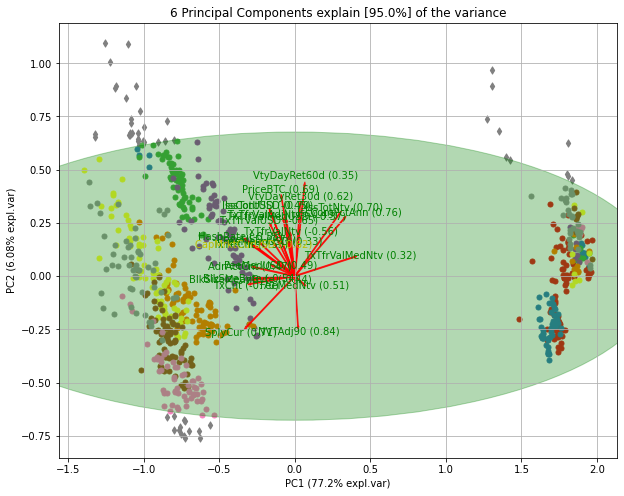

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0823e668b0>)

In [33]:
model.biplot(legend=False, SPE=True, hotellingt2=True, label = False)

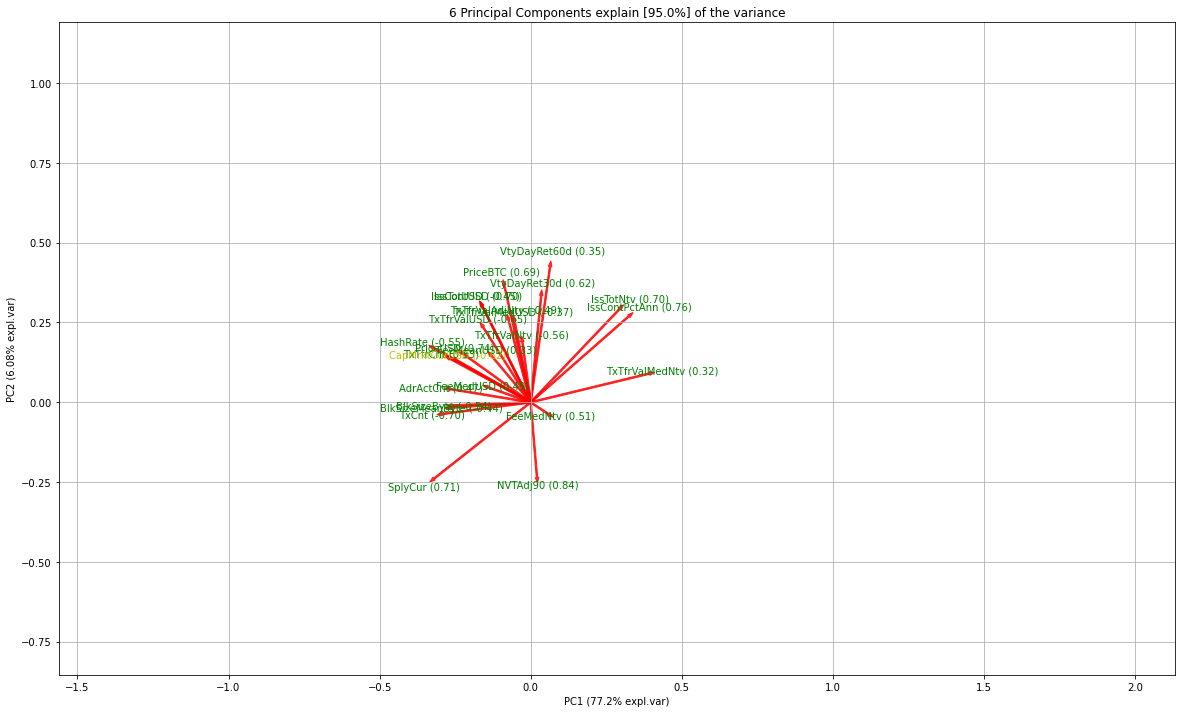

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0823cdeb20>)

In [34]:
model.biplot(cmap=None, label=False, legend=False,figsize=(20,12),visible=True)

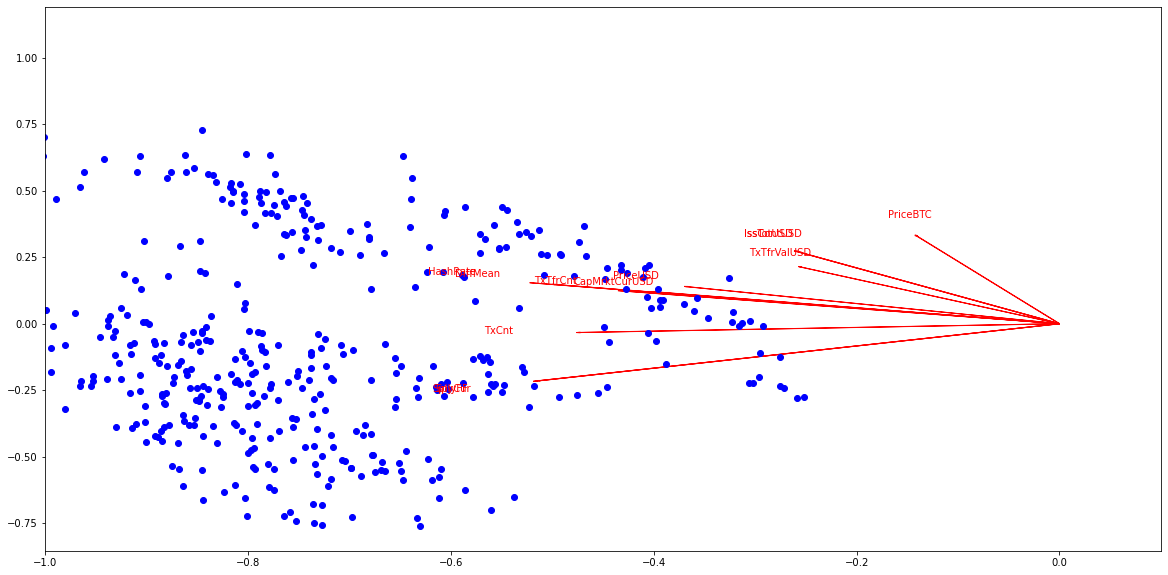

array(['CapMrktCurUSD', 'DiffMean', 'HashRate', 'IssContUSD', 'IssTotUSD',
       'PriceBTC', 'PriceUSD', 'SplyCur', 'SplyFF', 'TxCnt', 'TxTfrCnt',
       'TxTfrValUSD'], dtype=object)

In [40]:
from sklearn.decomposition import PCA

n = len(df.columns)

pca = PCA(n_components = n)
pca.fit(df)
xvector = pca.components_[0]
yvector = pca.components_[1]
xs = pca.transform(df)[:,0]
ys = pca.transform(df)[:,1]

#print(df.columns.values[17]) #vector priceUSD
#print(xvector[14])
plt.xlim(-1,0.1)
lim = np.sqrt(xvector[17]**2 + yvector[17]**2)
feat = []

for i in range(len(xvector)):
    if(np.sqrt(xvector[i]**2 + yvector[i]**2) >= lim and np.sign(xvector[i]) == np.sign(xvector[14])):
        plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
                  color='r', width=0.0005, head_width=0.0025)
        plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
                 list(df.columns.values)[i], color='r')
        feat.append(i)

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo')
    #plt.text(xs[i]*1.2, ys[i]*1.2, list(df.index)[i], color='b')

plt.show()
df.columns.values[feat]

## Eliminamos las variables que tienen una norma menor al vector PriceUSD y con distinta dirección

## Total de **variables restantes 11**

In [41]:
df_red = df[df.columns.values[feat]].copy()
df_red = df_red.drop(['PriceBTC'],axis =1)

In [42]:
#Con 29 variables

import dcor
# Create the distance method using distance_correlation
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2) 
# Apply the distance method pairwise to every column
rslt = df_red.apply(lambda col1: df_regresion_wo.apply(lambda col2: distcorr(col1, col2)))

pd.options.display.float_format = '{:,.2f}'.format
rslt

,CapMrktCurUSD,DiffMean,HashRate,IssContUSD,IssTotUSD,PriceUSD,SplyCur,SplyFF,TxCnt,TxTfrCnt,TxTfrValUSD
AdrActCnt,0.94,0.96,0.97,0.88,0.88,0.94,0.96,0.96,0.98,0.98,0.88
BlkSizeByte,0.95,0.94,0.95,0.87,0.87,0.94,0.96,0.96,0.98,0.96,0.88
BlkSizeMeanByte,0.94,0.95,0.96,0.87,0.87,0.94,0.96,0.96,0.98,0.96,0.87
CapMrktCurUSD,1.00,0.93,0.95,0.94,0.94,1.00,0.92,0.92,0.94,0.93,0.87
DiffMean,0.93,1.00,0.99,0.92,0.92,0.93,0.95,0.95,0.95,0.95,0.84
FeeMeanNtv,0.18,0.18,0.19,0.18,0.18,0.18,0.20,0.20,0.18,0.18,0.15
FeeMeanUSD,0.93,0.89,0.90,0.90,0.90,0.93,0.85,0.85,0.88,0.88,0.84
FeeMedNtv,0.55,0.58,0.58,0.55,0.55,0.55,0.57,0.57,0.58,0.61,0.50
FeeMedUSD,0.88,0.84,0.85,0.82,0.82,0.88,0.83,0.83,0.86,0.82,0.79
HashRate,0.95,0.99,1.00,0.93,0.93,0.95,0.96,0.96,0.96,0.96,0.86


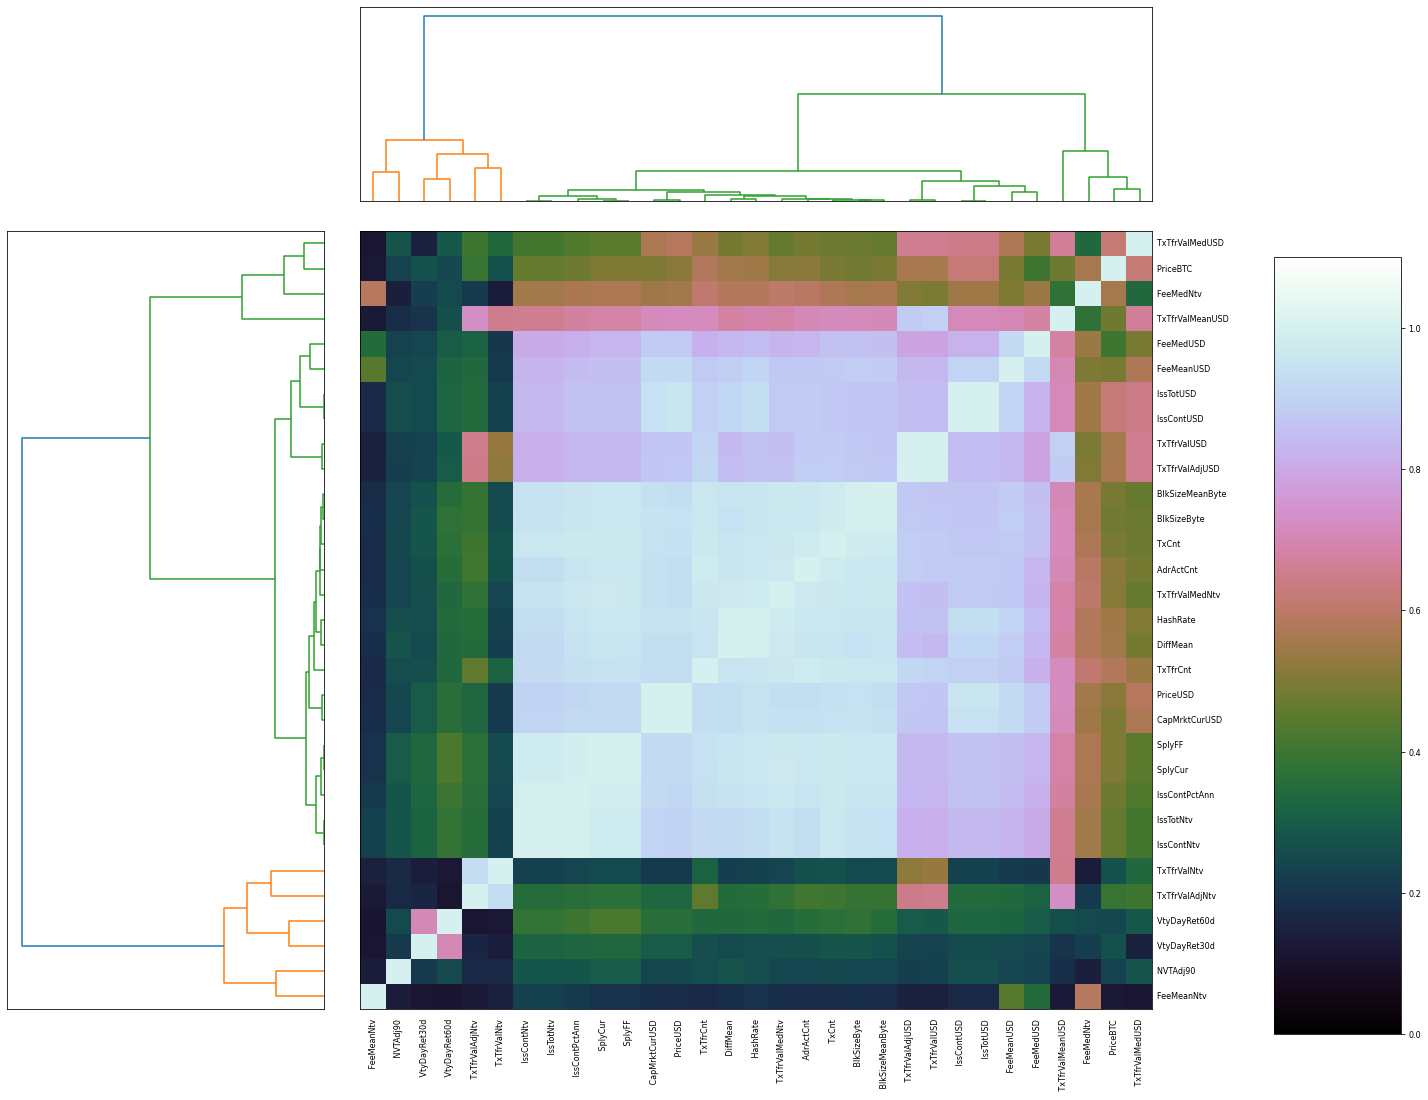

In [43]:
from biokit.viz import heatmap

df_regresion_wo.rename(index=str, columns={"Gross pay transform": "Gross pay tr"}, inplace=True)
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2)
rslt = df_regresion_wo.apply(lambda col1: df_regresion_wo.apply(lambda col2: distcorr(col1, col2)))
h = heatmap.Heatmap(rslt)
h.plot(vmin=0.0, vmax=1.1, cmap='cubehelix')
fig = plt.gcf()
fig.set_size_inches(22, 18)
plt.gcf().get_axes()[1].invert_xaxis();
plt.savefig('ETH_dendograma.png', dpi = 100)